<a href="https://colab.research.google.com/github/Berenice2018/dog-breed133-classifier/blob/master/dog_app.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](https://github.com/Berenice2018/dog-breed133-classifier/blob/master/images/sample_dog_output.png?raw=1)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Write your Algorithm
* [Step 6](#step6): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

Make sure that you've downloaded the required human and dog datasets:
* Download the [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).  Unzip the folder and place it in this project's home directory, at the location `/dog_images`. 

* Download the [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip).  Unzip the folder and place it in the home directory, at location `/lfw`.  

*Note: If you are using a Windows machine, you are encouraged to use [7zip](http://www.7-zip.org/) to extract the folder.*

In the code cell below, we save the file paths for both the human (LFW) dataset and dog dataset in the numpy arrays `human_files` and `dog_files`.

In [1]:
# save the model on Google Drive, link Google drive to this notebook
from google.colab import drive
drive.mount('/content/gdrive')

# After executing this cell above, Drive
# files will be present in "/content/drive/My Drive".
!ls "/content/gdrive/My Drive/ColabUdacity/dog-breed-classifier/"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
dog_app.ipynb  haarcascades  lfw     my_test_images		Untitled0.ipynb
dogImages      images	     models  uda-p2-dog-breed133.ipynb


In [4]:
import numpy as np
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

import torchvision.transforms as transforms
import torch
import torchvision.models as models
import os
from torchvision import datasets
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


# check if CUDA is available
use_cuda = torch.cuda.is_available()
print('cuda is available: ', use_cuda)

data_dir = "/content/gdrive/My Drive/ColabUdacity/dog-breed-classifier/"


cuda is available:  True


In [90]:
# load filenames for human and dog images
human_files = np.array(glob(data_dir + "lfw/*/*"))
print('There are %d total human images.' % len(human_files))

dog_files = np.array(glob(data_dir + "dogImages/*/*/*"))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8351 total dog images.


<a id='step1'></a>
## Step 1: Detect Humans

In this section, we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.  In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

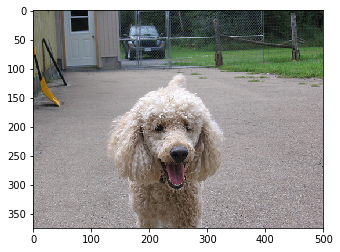

Number of faces detected: 0


In [92]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier(data_dir +'haarcascades/haarcascade_frontalface_alt.xml')

def show_image(imgpath):
    # load color (BGR) image
    #img = cv2.imread(human_files[0])
    img = cv2.imread(imgpath)
    # convert BGR image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # find faces in image
    faces = face_cascade.detectMultiScale(gray)

    # get bounding box for each detected face
    for (x,y,w,h) in faces:
        # add bounding box to color image
        cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)

    # convert BGR image to RGB for plotting
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # display the image, along with bounding box
    plt.imshow(cv_rgb)
    plt.show()
    return faces
  
# print number of faces detected in the image
print('Number of faces detected:', len(show_image(dog_files[1])))

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [0]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 
(You can print out your results and/or write your percentages in this cell)

*100% of faces  in human_files_short detected,  and 
7% of faces in dog_files_short detected*

In [0]:
from tqdm import tqdm

human_files_short = human_files[:100]
dog_files_short = dog_files[:100]
#-#-# Do NOT modify the code above this line. #-#-#

In [0]:
## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.

counter = 0

counter = 0
for i, img_path in enumerate(human_files_short):
    if face_detector(img_path):
        counter += 1

print('Number of faces detected, in human_files:', counter)

counter = 0
for i, img_path in enumerate(dog_files_short):
    if face_detector(img_path):
        counter += 1
print('Number of faces detected in dog_files: ', counter)

Number of faces detected, in human_files: 100
Number of faces detected in dog_files:  7


We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [0]:
### (Optional) 
### TODO: Test performance of anotherface detection algorithm.
### Feel free to use as many code cells as needed.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [73]:


# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# move model to GPU if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
VGG16.to(device)
    
print('model is on cuda: ', next(VGG16.parameters()).is_cuda)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
553433881it [00:06, 81661077.44it/s]


model is on cuda:  True


Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

### (IMPLEMENTATION) Making Predictions with a Pre-trained Model

In the next code cell, you will write a function that accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output should always be an integer between 0 and 999, inclusive.

Before writing the function, make sure that you take the time to learn  how to appropriately pre-process tensors for pre-trained models in the [PyTorch documentation](http://pytorch.org/docs/stable/torchvision/models.html).

In [0]:
#test = 'images/American_water_spaniel_00648.jpg'

# My helper function for pre-processing a PIL image
def prepocess_img(img_path):
    ## Load and pre-process an image from the given img_path
    pil_image = Image.open(img_path)
                     
    my_normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
    my_transforms = transforms.Compose([
                       transforms.Resize(256),
                       transforms.CenterCrop(224),
                       transforms.ToTensor(),
                       my_normalize])
    
    image = my_transforms(pil_image)
      
    image = image.unsqueeze_(0)
    #print('img was pre-processed. ', image.shape)
    return image
  

In [0]:

def VGG16_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    
    ## TODO: Complete the function.
    img_as_tensor = prepocess_img(img_path).to(device)
        
    output = VGG16(img_as_tensor)
    #print('output:', output.shape)
    
    ## Return the *index* of the predicted class for that image
    probabilities = torch.exp(output)
    _, top = probabilities.topk(1, dim=1)
    #print('top class: ', top)
    return top # predicted class index

#test = data_dir +'images/American_water_spaniel_00648.jpg'
#VGG16_predict(test)

### (IMPLEMENTATION) Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

Use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [0]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    ## TODO: Complete the function.
    index = VGG16_predict(img_path)
    #print('index: ', index[0])
    return (index > 150) and (index < 269)

### (IMPLEMENTATION) Assess the Dog Detector

__Question 2:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 

*With VGG16 as pre-trained model, 
1% of the files in human_files_short were classified as dogs.  
97% of the files in dog_files_short were classified as dogs. *


In [0]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.

def test_performance(detector, *args):
    print('test_performance with {} started'.format(detector))
    counter = 0
    for img_path in human_files_short:
        if detector(img_path):
            counter += 1

    print('{}/{} of detected dogs, in human_files:'.format(counter, len(human_files_short)))

    counter = 0
    for img_path in dog_files_short:
        if detector(img_path):
            counter += 1
    print('{}/{} of detected dogs, in dog_files: '.format(counter, len(human_files_short)))


In [0]:

    
test_performance(dog_detector)


test_performance with <function dog_detector at 0x7fb7d5a27840> started
1/100 of detected dogs, in human_files:
97/100 of detected dogs, in dog_files: 


We suggest VGG-16 as a potential network to detect dog images in your algorithm, but you are free to explore other pre-trained networks (such as [Inception-v3](http://pytorch.org/docs/master/torchvision/models.html#inception-v3), [ResNet-50](http://pytorch.org/docs/master/torchvision/models.html#id3), etc).  Please use the code cell below to test other pre-trained PyTorch models.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [0]:
### (Optional) 
### TODO: Report the performance of another pre-trained network.
### Feel free to use as many code cells as needed.

resnet = models.resnet50(pretrained=True).to(device)


With ResNet50 as pre-trained model, 0% of the files in human_files_short were classified as dogs. 0% of the files in dog_files_short were classified as dogs.

In [0]:

def resnet_predict(img_path):
    imgtensor = prepocess_img(img_path).to(device)
    
    output = resnet(imgtensor)
    probs = torch.exp(output)
    _, top_classes = probs.topk(1, dim=1)
    return top_classes


def resnet_dog_detector(path):
    index = resnet_predict(path)
    #print(index)
    return (index > 150) and (index < 269)

# test the performance with ResNet18
test_performance(resnet_dog_detector)

test_performance with <function resnet_dog_detector at 0x7fb7b4bea730> started
0/100 of detected dogs, in human_files:
0/100 of detected dogs, in dog_files: 


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 10%.  In Step 4 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="/content/gdrive/My Drive/ColabUdacity/dog-breed-classifier/images/Brittany_02625.jpg" width="100"> | <img src="/content/gdrive/My Drive/ColabUdacity/dog-breed-classifier/images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="https://github.com/Berenice2018/dog-breed133-classifier/blob/master/images/Curly-coated_retriever_03896.jpg?raw=1" width="200"> | <img src="https://github.com/Berenice2018/dog-breed133-classifier/blob/master/images/American_water_spaniel_00648.jpg?raw=1" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="https://github.com/Berenice2018/dog-breed133-classifier/blob/master/images/Labrador_retriever_06457.jpg?raw=1" width="150"> | <img src="https://github.com/Berenice2018/dog-breed133-classifier/blob/master/images/Labrador_retriever_06455.jpg?raw=1" width="240"> | <img src="https://github.com/Berenice2018/dog-breed133-classifier/blob/master/images/Labrador_retriever_06449.jpg?raw=1" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dog_images/train`, `dog_images/valid`, and `dog_images/test`, respectively).  You may find [this documentation on custom datasets](http://pytorch.org/docs/stable/torchvision/datasets.html) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [11]:


train_dir = os.path.join(data_dir, 'dogImages/train')
valid_dir = os.path.join(data_dir, 'dogImages/valid')
test_dir = os.path.join(data_dir, 'dogImages/test')

### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

batch_size = 64
num_workers = 0
img_size = 224

mean = [0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]
    
my_transform = transforms.Compose([#p.torch_transform(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(16),
    transforms.RandomResizedCrop(img_size),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
      ])

valid_transform = transforms.Compose([
    transforms.Resize(320),
    transforms.CenterCrop(img_size),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])
train_data = datasets.ImageFolder(train_dir, transform=my_transform)
valid_data = datasets.ImageFolder(valid_dir, transform = valid_transform)
test_data = datasets.ImageFolder(test_dir, transform = valid_transform)

print('length of train_data = {} |valid_data= {} | test_data= {}'.format(len(train_data), len(valid_data), len(test_data)))

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

loaders_scratch = [train_loader, valid_loader, test_loader]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('device: ', device)

length of train_data = 6680 |valid_data= 835 | test_data= 836
device:  cuda


**Question 3:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?


**Answer:**
I did some data augmentation by 

1.   randomly flipping the image with a 50% probability for the image being flipped
2.   randomly rotating by 16 degrees

3. resizing and cropping the images to 320 px and 224 px respectively. I chose 224 px as final image size, since I knew that ResNet and other well-known pre-trained models request this size, too. 

4. normalizing the images by the values which are also special to ImageNet. 


The given data set of 6,500 images is quite small in regards to 133 classes. Data augmentation helps in enlarging the data set, so that the network gets more input to learn from. 




In [0]:

# function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

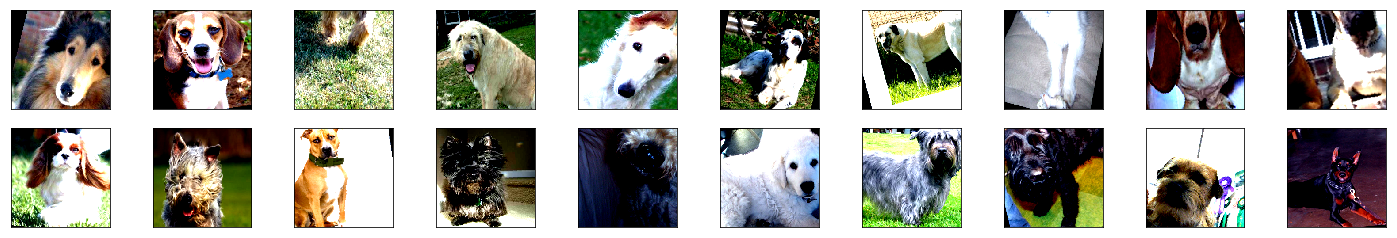

In [0]:
# get a batch of training images
dataiter = iter(train_loader)
images, _ = dataiter.next()
images = images.numpy() # convert images to numpy

# plot the images of the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])


**Answer**:

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  Use the template in the code cell below.

In [13]:


def weights_init_normal(m):
    '''Takes in a module and initializes all linear layers with weight
       values taken from a normal distribution.'''
    classname = m.__class__.__name__
    # for every Linear layer in a model
    if classname.find('Linear') != -1:
        n = m.in_features
        # m.weight.data shoud be taken from a normal distribution
        m.weight.data.normal_(0, 1/np.sqrt(n))
        # m.bias.data should be 0
        m.bias.data.fill_(0)
        
        
# normalize each layer:
class MyBatchNormLayer(nn.Module):
    def __init__(self, input_number, filter_number, stride=2, kernel_size=3, padding=1):
        super().__init__()
        self.conv = nn.Conv2d(input_number, filter_number, kernel_size=kernel_size,
                             stride=stride, bias=False, padding=1)
        self.normalized = nn.BatchNorm2d(filter_number)
    
    def forward(self,x):
        x = F.relu(self.conv(x))
        #print('MyBatchNormLayer x.shape= ', x.shape)
        return self.normalized(x)

    
class ResnetLayer(MyBatchNormLayer):
    def forward(self, x): return x + super().forward(x)
    
    
class MyConvBnNet(nn.Module):
    def __init__(self, layers, classes_number, dropout=0):
        super().__init__()
        # define the first convolutional layer manually
        self.conv1 = MyBatchNormLayer(3, 64,kernel_size=7, stride=2, padding=1)
        self.pool1 = nn.MaxPool2d(3,2)
        
        self.layers1 = nn.ModuleList([MyBatchNormLayer(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        self.layers2 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i+1], 1) for i in range(len(layers) - 1)])
        self.layers3 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i+1], 1) for i in range(len(layers) - 1)])
        self.layers4 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i+1], 1) for i in range(len(layers) - 1)])
        self.layers5 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i+1], 1) for i in range(len(layers) - 1)])
        self.layers6 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i+1], 1) for i in range(len(layers) - 1)])
        self.layers7 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i+1], 1) for i in range(len(layers) - 1)])
        self.layers8 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i+1], 1) for i in range(len(layers) - 1)])
        
        #self.linear1 = nn.Linear(layers[-1], 512)
        self.outlayer = nn.Linear(layers[-1], classes_number)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        for lyr1 ,lyr2, lyr3, lyr4, lyr5, lyr6 in zip(
            self.layers1, self.layers2, self.layers3, self.layers4, self.layers5, self.layers6): 
            x = lyr4(lyr3(lyr2(lyr1(x))))
            x =  lyr6(lyr5(x)) # lyr8(lyr7(lyr6(lyr5(x))))
        x = F.adaptive_max_pool2d(x,1)
        #print('MyConvBnNet after adaptive_max_pool2d, x.shape=', x.shape)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        #x = self.linear1(x)
        x = self.outlayer(x)
        return F.log_softmax(x, dim= -1)


# check if CUDA is available
use_cuda = torch.cuda.is_available()
print('cuda available: ', use_cuda)

# instantiate the CNN
#model_scratch = MyConvBnNet([10, 20, 40], 133)
model_scratch = MyConvBnNet([64, 128, 256, 512, 1024], 133, 0.1)
print(model_scratch)

model_scratch.apply(weights_init_normal)

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()
print('model is on cuda: ', next(model_scratch.parameters()).is_cuda)

cuda available:  True
MyConvBnNet(
  (conv1): MyBatchNormLayer(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(1, 1), bias=False)
    (normalized): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (pool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (layers1): ModuleList(
    (0): MyBatchNormLayer(
      (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (normalized): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): MyBatchNormLayer(
      (conv): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (normalized): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): MyBatchNormLayer(
      (conv): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (normalized): BatchNorm2d(512, eps=1e-05, momentum=0

__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  





__Answer:__ 

I started with a basic network architecture consisting of just a few Conv layers with MaxPooling  and 2 linear layers on top. I only achieved an accuracy of 2-3 %. 

I concluded that my architecture was not deep enough. After some research, I decided to build some basic and normalized ResNet blocks. Normalizing each layer helped much. I followed a webinar by Jeremy Howard (fast.ai) 

I also applied the technique to initialize the weights of the linear layers, we had learnt in one lesson. 

Using *MyBatchNormLayer* speeds up the training, and helps avoiding vanishing gradients

*ResnetLayer* s can be stacked to deep neural networks without making the input too small by using "usual"  Convolutional layers mith MaxPooling. 

*MyConvBnNet* finally stacks module layers to a deep residual neural network. 





### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and the optimizer as `optimizer_scratch` below.

In [0]:

### TODO: select loss function
criterion_scratch = nn.NLLLoss()

### TODO: select optimizer
#optimizer_scratch = optim.SGD(model_scratch.parameters(), lr=0.001, momentum=0.9)
optimizer_scratch = optim.Adam(model_scratch.parameters(), lr=1e-4)
######### change the position of optim.step() in the train section
#scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer_scratch, patience = 3, factor=0.1)

scheduler_scratch = optim.lr_scheduler.MultiStepLR(optimizer_scratch, [10, 18, 26, 32], 0.2)

In [0]:
# Visualize plot
def plot_loss_acc(n_epochs, train_losses, valid_losses, valid_accuracies):
    fig, (ax1, ax2) = plt.subplots(figsize=(14,6), ncols=2)
    ax1.plot(valid_losses, label='Validation loss')
    ax1.plot(train_losses, label='Training loss')
    ax1.legend(frameon=False)
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    #x_ticks = [x for x in range(0,n_epochs,2)]
    #plt.xticks(x_ticks)
    
    ax2.plot(valid_accuracies, label = 'Validation accuracy')
    ax2.legend(frameon=False)
    ax2.set_xlabel('Epochs')
    
    plt.tight_layout()

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_scratch.pt'`.

In [0]:
# helper functions
import datetime

def get_time():
      hour = datetime.datetime.today().hour +2
      minute = datetime.datetime.today().minute
      second = datetime.datetime.today().second
      return hour, minute, second

def train_epoch(model, dataloader, criterion, optimizer, train_on_gpu):
    # initialize variables to monitor training and validation loss
    train_loss = 0.0
    train_accuracy = 0.0
    correct = 0.0
    total = 0.0
    
    for batch_idx, (data, target) in enumerate(dataloader):
        # move to GPU
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
            
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        
        ## find the loss and update the model parameters accordingly
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        # get the loss per batch and accumulate
        train_loss += loss.item()
        
        # get the class, highest probability
        probabilities = torch.exp(output)
        _, top_class = probabilities.topk(1, dim=1)
        # The following line is equivalent to the previous (?)
        #_, top_class = torch.max(probabilities, dim=1)
        
        # check if the predicted class is correct
        equals = top_class == target.view(*top_class.shape)
        # 
        train_accuracy += torch.mean(equals.type(torch.FloatTensor))

    return train_loss, train_accuracy


def validate_epoch(model, dataloader, criterion, train_on_gpu):
    valid_loss = 0.0
    valid_accuracy = 0.0
    correct = 0.0
    total = 0.0
    
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(dataloader):
            # move to GPU
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            output = model(data)
            loss = criterion(output,target)
            
            valid_loss += loss.item()

            ps = torch.exp(output)
            _ , top_class = ps.topk(1,dim = 1)
            #_, top_class = torch.max(ps, dim=1)
            equals = top_class == target.view(*top_class.shape) # shape is (batch size x 1)
            valid_accuracy += torch.mean(equals.type(torch.FloatTensor))

    return valid_loss, valid_accuracy

In [0]:

def train(n_epochs, loaders, model, optimizer, criterion, scheduler, use_cuda, save_path):
    print('Training started at ', get_time())
    
    valid_losses = []
    train_losses = []
    valid_accuracies = []
    
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(n_epochs):
        
         # initialize variables to monitor training and validation loss
        training_loss = 0.0
        training_accuracy = 0.0
    
        if scheduler is not None:
          scheduler.step()
        
        ###################
        # train the model #
        model.train()
        training_loss, training_accuracy = train_epoch(model, loaders[0], criterion, optimizer, use_cuda)
    
        
        ######################    
        # validate the model #
        model.eval()
        validation_loss, validation_accuracy = validate_epoch(model, loaders[1], criterion, use_cuda)
        
        #if scheduler is not None:
          #scheduler.step(validation_loss)
        
        ###### print training/validation statistics 
        # calculate the average loss per epoch
        training_loss = training_loss/len(loaders[0])
        train_losses.append(training_loss)
        
        training_accuracy = training_accuracy/len(loaders[0])
        
        validation_loss = validation_loss/len(loaders[1])
        valid_losses.append(validation_loss)
        
        validation_accuracy = validation_accuracy/len(loaders[1])
        valid_accuracies.append(validation_accuracy)
        
        hour, minute, second = get_time()
        print('Epoch: {} at {}:{}:{} \tTrain. Loss: {:.6f} \tValid. Loss: {:.6f} \t Accur.: {:.10f}'.format(
                  epoch,
                  hour, minute, second,
                  training_loss,
                  #training_accuracy, 
                  validation_loss,
                  validation_accuracy ))
        
        ###### TODO: save the model if validation loss has decreased
        if validation_loss <= valid_loss_min:
            '''print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
                valid_loss_min,
                validation_loss))'''
            print('Validation loss decreased by {:.6f}'.format(validation_loss - valid_loss_min))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = validation_loss
            
            
    ##### visualize
    plot_loss_acc(n_epochs, train_losses, valid_losses, valid_accuracies)
    
    return model


Training started at  (14, 20, 50)
Epoch: 0 at 14:20:50 	Train. Loss: 4.086024 	Valid. Loss: 3.662756 	 Accur.: 0.1633184403
Validation loss decreased by -inf
Epoch: 1 at 14:24:37 	Train. Loss: 3.979528 	Valid. Loss: 3.929882 	 Accur.: 0.1517857164
Epoch: 2 at 14:28:25 	Train. Loss: 3.821782 	Valid. Loss: 3.469462 	 Accur.: 0.1662946492
Validation loss decreased by -0.193294
Epoch: 3 at 14:32:14 	Train. Loss: 3.740591 	Valid. Loss: 4.690178 	 Accur.: 0.1718750000
Epoch: 4 at 14:36:2 	Train. Loss: 3.569861 	Valid. Loss: 4.663328 	 Accur.: 0.2124255896
Epoch: 5 at 14:39:54 	Train. Loss: 3.562402 	Valid. Loss: 4.200979 	 Accur.: 0.1774553508
Epoch: 6 at 14:43:42 	Train. Loss: 3.503059 	Valid. Loss: 3.429696 	 Accur.: 0.2064732164
Validation loss decreased by -0.039766
Epoch: 7 at 14:47:33 	Train. Loss: 3.408412 	Valid. Loss: 3.453786 	 Accur.: 0.2280505896
Epoch: 8 at 14:51:24 	Train. Loss: 3.333300 	Valid. Loss: 3.051708 	 Accur.: 0.2377232164
Validation loss decreased by -0.377988
Epoch:

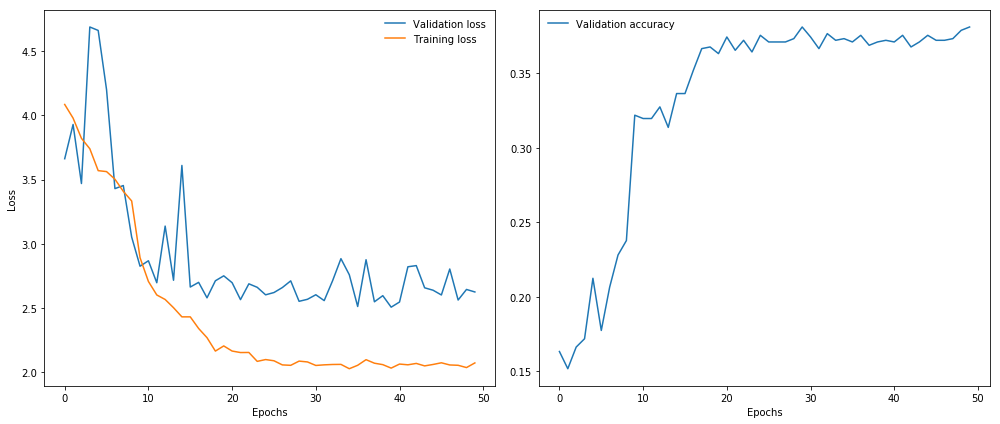

In [0]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# train the model
model_scratch = train(50, loaders_scratch, model_scratch, optimizer_scratch, 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images.  Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 10%.

In [0]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.
    
    print('test started at ', get_time())
    model.eval()
    for batch_idx, (data, target) in enumerate(loaders[2]):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('test finished at ', get_time())
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

In [0]:


# call test function    
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 2.558218


Test Accuracy: 39% (328/836)


---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively). 

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [0]:
## TODO: Specify data loaders
# same as in part 2

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify dog breed.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [28]:

## TODO: Specify model architecture 
#transfermodel = models.resnet152(pretrained=True)
#transfermodel.fc

transfermodel = models.densenet161(pretrained=True)
transfermodel.classifier

Linear(in_features=2208, out_features=1000, bias=True)

In [0]:
for param in transfermodel.parameters():
    param.requires_grad = False
    
fc_in = transfermodel.classifier.in_features

transferclassifier = nn.Sequential(
                        nn.BatchNorm1d(fc_in),
                        nn.Linear(fc_in, 133),
                        #nn.ReLU(),
                        #nn.Linear(1024, 133)
                        )

#transfermodel.fc = transferclassifier # resnet
transfermodel.classifier = transferclassifier
transfermodel.apply(weights_init_normal)

if use_cuda:
    transfermodel.cuda()
    


__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 

Given the small data set which has approx. 40-50 images per category, I decided for a pre-trained deep model like of the ResNet and DenseNet family, which achieve good accuracy results on image classification tasks. They were trained on millions of images and are able to extract as many  features as possible. 

Again, I initialized the weights for the linear layers, so no random weight initialization.

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/master/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/master/optim.html).  Save the chosen loss function as `criterion_transfer`, and the optimizer as `optimizer_transfer` below.

In [0]:
transfer_criterion = nn.CrossEntropyLoss()
transfer_optim = optim.Adam(transfermodel.parameters(), lr=2e-3)
#transfer_scheduler = optim.lr_scheduler.MultiStepLR(transfer_optim, [5,10,14,17], 0.1)
transfer_scheduler = optim.lr_scheduler.StepLR(transfer_optim, 6, 0.05)


### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

Training started at  (22, 40, 56)
Epoch: 0 at 22:44:59 	Train. Loss: 2.007033 	Valid. Loss: 0.588900 	 Accur.: 0.8511905074
Validation loss decreased by -inf
Epoch: 1 at 22:49:3 	Train. Loss: 0.753187 	Valid. Loss: 0.393987 	 Accur.: 0.8872767687
Validation loss decreased by -0.194914
Epoch: 2 at 22:53:5 	Train. Loss: 0.589197 	Valid. Loss: 0.428958 	 Accur.: 0.8701637387
Epoch: 3 at 22:57:7 	Train. Loss: 0.514217 	Valid. Loss: 0.349023 	 Accur.: 0.8995535970
Validation loss decreased by -0.044963
Epoch: 4 at 23:1:10 	Train. Loss: 0.500675 	Valid. Loss: 0.344222 	 Accur.: 0.8995535970
Validation loss decreased by -0.004802
Epoch: 5 at 23:5:12 	Train. Loss: 0.457501 	Valid. Loss: 0.352882 	 Accur.: 0.8861607313
Epoch: 6 at 23:9:15 	Train. Loss: 0.404042 	Valid. Loss: 0.327781 	 Accur.: 0.8895089030
Validation loss decreased by -0.016441
Epoch: 7 at 23:13:18 	Train. Loss: 0.396335 	Valid. Loss: 0.318293 	 Accur.: 0.8950892687
Validation loss decreased by -0.009487
Epoch: 8 at 23:17:21 	T

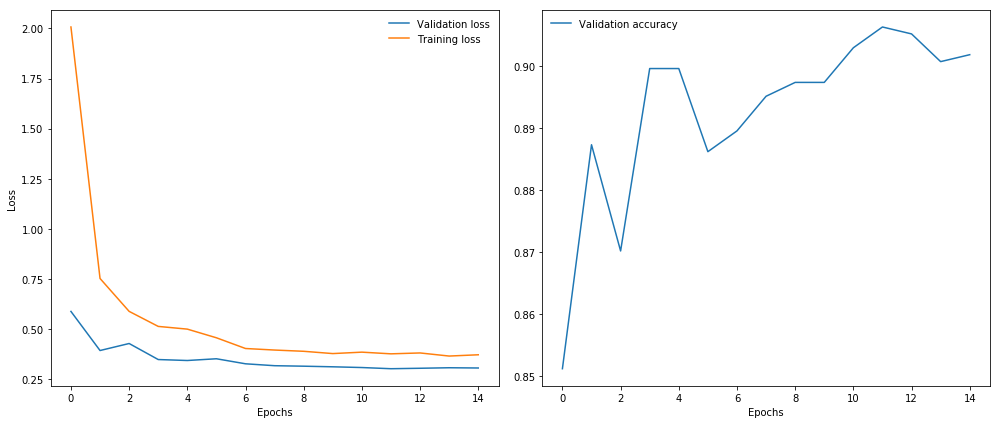

In [31]:
# train the model
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

#n_epochs, loaders, model, optimizer, criterion, scheduler,use_cuda, save_path
transfermodel = train (15, 
                       [train_loader, valid_loader, test_loader],
                      transfermodel,
                      transfer_optim,
                      transfer_criterion,
                       transfer_scheduler,
                       use_cuda,
                       'model_transfer.pt'
                      )

# load the model that got the best validation accuracy (uncomment the line below)
transfermodel.load_state_dict(torch.load('model_transfer.pt'))

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [32]:
test(loaders_scratch, transfermodel, transfer_criterion, use_cuda)

test started at  (23, 41, 55)
test finished at  (23, 42, 22)
Test Loss: 0.348895


Test Accuracy: 88% (737/836)


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by your model.  

In [0]:
import torch
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

# list of class names by index, i.e. a name can be accessed like class_names[0]
class_names = [item[4:].replace("_", " ") for item in train_data.classes]

def predict_breed_transfer(img_path):
    transfermodel.eval()
    transfermodel.cpu()
    with torch.no_grad():
      # load the image and return the predicted breed
      img = prepocess_img(img_path)
      output = transfermodel(img)
      probabilities = torch.exp(output)
      _, top_class = probabilities.topk(1, dim=1)
      return class_names[top_class]

In [61]:
print(predict_breed_transfer(data_dir +'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'))


Affenpinscher


---
<a id='step5'></a>
## Step 5: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `human_detector` functions developed above.  You are __required__ to use your CNN from Step 4 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](https://github.com/Berenice2018/dog-breed133-classifier/blob/master/images/sample_human_output.png?raw=1)


### (IMPLEMENTATION) Write your Algorithm

In [0]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.

def run_app(img_path):

    ## handle cases for a human face, dog, and neither
    dog = dog_detector(img_path)
    if dog:
      print('It is a dog')
    else:
      if face_detector(img_path):
        print('It is a human ')
      else:
        print('What is this? ')
    
    show_image(img_path)
    print('Looking like a ', predict_breed_transfer(img_path))


---
<a id='step6'></a>
## Step 6: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that _you_ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ (Three possible points for improvement)

It is a dog


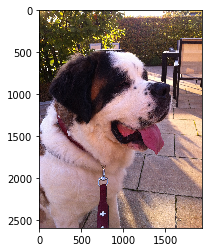

Looking like a  English setter
It is a dog


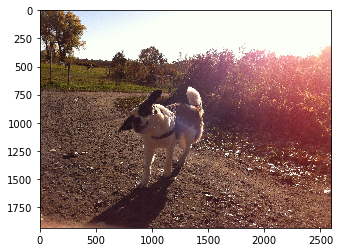

Looking like a  Pointer
It is a dog


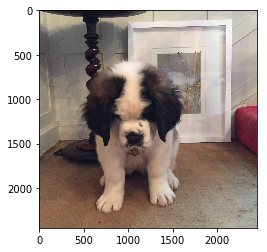

Looking like a  Saint bernard
It is a dog


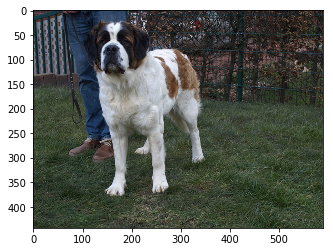

Looking like a  Saint bernard
It is a dog


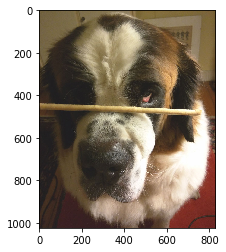

Looking like a  Saint bernard
It is a dog


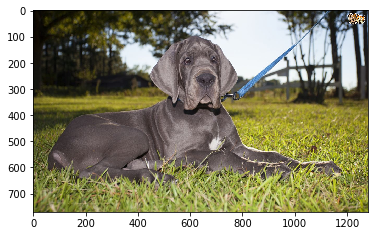

Looking like a  Neapolitan mastiff
It is a dog


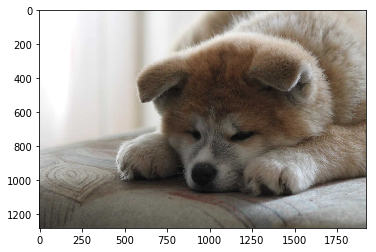

Looking like a  Akita
It is a dog


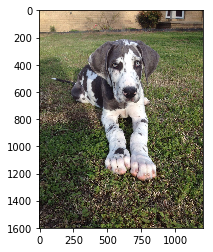

Looking like a  Great dane
It is a dog


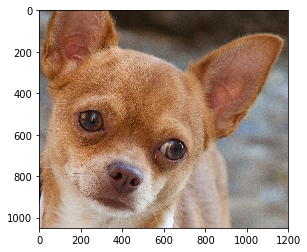

Looking like a  Chihuahua
It is a dog


In [0]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.

my_files = np.array(glob(data_dir + "my_test_images/*"))


## suggested code, below
#for file in np.hstack((human_files[:3], dog_files[:3])):
for file in my_files:
    run_app(file)